In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import seaborn as sns

pd.options.display.max_rows=10
pd.options.display.float_format="{:.1f}".format

e:\python 3.7.6\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
e:\python 3.7.6\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
e:\python 3.7.6\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
e:\python 3.7.6\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym

In [2]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the examples
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

In [3]:
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

# Calculate the Z-scores of each column in the test set.
test_df_mean = test_df.mean()
test_df_std = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

In [4]:
# Create an empty list that will eventually hold all created feature columns.
feature_columns = []

# We scaled all the columns, including latitude and longitude, into their
# Z scores. So, instead of picking a resolution in degrees, we're going
# to use resolution_in_Zs.  A resolution_in_Zs of 1 corresponds to 
# a full standard deviation. 
resolution_in_Zs = 0.3  # 3/10 of a standard deviation.

# Create a bucket feature column for latitude.
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df_norm['latitude'])), 
                                     int(max(train_df_norm['latitude'])), 
                                     resolution_in_Zs))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)

# Create a bucket feature column for longitude.
longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df_norm['longitude'])), 
                                      int(max(train_df_norm['longitude'])), 
                                      resolution_in_Zs))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, 
                                                longitude_boundaries)

# Create a feature cross of latitude and longitude.
latitude_x_longitude = tf.feature_column.crossed_column([latitude, longitude], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(latitude_x_longitude)
feature_columns.append(crossed_feature)  

# Represent median_income as a floating-point value.
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

# Represent population as a floating-point value.
population = tf.feature_column.numeric_column("population")
feature_columns.append(population)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [5]:
def plot_the_loss_curve(epochs, mse):

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")

    plt.plot(epochs, mse, label="Loss")
    plt.legend()
    plt.ylim([mse.min()*0.95, mse.max() * 1.03])
    plt.show()  

In [6]:
def create_model(my_learning_rate, feature_layer):
    model=tf.keras.models.Sequential()
    model.add(feature_layer)
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                 loss="mean_squared_error",
                 metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

def train_model(model, dataset, epochs, batch_size, label_name):
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)

  # Get details that will be useful for plotting the loss curve.
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    rmse = hist["mean_squared_error"]

    return epochs, rmse 

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Epoch 1/15
17000/17000 [==============================] - 1s 77us/sample - loss: 0.8276 - mean_squared_error: 0.8276
Epoch 2/15
17000/17000 [==============================] - 1s 43us/sample - loss: 0.5826 - mean_squared_error: 0.5826
Epoch 3/15
17000/17000 [==============================] - 1s 31us/sample - loss: 0.4740 - mean_squared_error: 0.4740
Epoch 4/15
17000/17000 [==============================] - 1s 33us/sample - loss: 0.4251 - mean_squared_error: 0.4251
Epoch 5/15
17000/17000 [==============================] - 1s 38us/sample - loss: 0.4092 - mean_squared_error: 0.4092
Epoch 6/15
17000/17000 [==============================] - 1s 37us/s

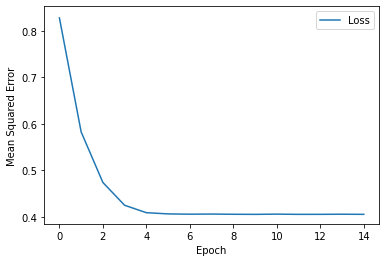


 Evaluate the linear regression model against the test set:
3000/3000 [==============================] - 0s 36us/sample - loss: 0.4334 - mean_squared_error: 0.4334


[0.4334163963794708, 0.43341643]

In [7]:
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = "median_house_value"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set.
epochs, mse = train_model(my_model, train_df_norm, epochs, batch_size, label_name)
plot_the_loss_curve(epochs, mse)

test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

In [27]:
def create_model(my_learning_rate, my_feature_layer):
    model=tf.keras.models.Sequential()
    model.add(my_feature_layer)
    model.add(tf.keras.layers.Dense(units=20, activation="relu", name="Hidden1"))
    model.add(tf.keras.layers.Dense(units=12, activation="relu", name="Hidden2"))
    model.add(tf.keras.layers.Dense(units=1, name="output"))
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                 loss="mean_squared_error",
                 metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [25]:
def train_model(model, dataset, epochs, label_name, batch_size=None):
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True) 
    epochs = history.epoch
  
    hist = pd.DataFrame(history.history)
    mse = hist["mean_squared_error"]

    return epochs, mse

Epoch 1/20
17000/17000 [==============================] - 1s 47us/sample - loss: 0.6675 - mean_squared_error: 0.6675
Epoch 2/20
17000/17000 [==============================] - 1s 35us/sample - loss: 0.4250 - mean_squared_error: 0.4250
Epoch 3/20
17000/17000 [==============================] - 1s 47us/sample - loss: 0.3939 - mean_squared_error: 0.3939
Epoch 4/20
17000/17000 [==============================] - 1s 35us/sample - loss: 0.3863 - mean_squared_error: 0.3863
Epoch 5/20
17000/17000 [==============================] - 1s 38us/sample - loss: 0.3841 - mean_squared_error: 0.3841
Epoch 6/20
17000/17000 [==============================] - 1s 47us/sample - loss: 0.3807 - mean_squared_error: 0.3807
Epoch 7/20
17000/17000 [==============================] - 1s 40us/sample - loss: 0.3793 - mean_squared_error: 0.3793
Epoch 8/20
17000/17000 [==============================] - 1s 53us/sample - loss: 0.3785 - mean_squared_error: 0.3785
Epoch 9/20
17000/17000 [==============================] - 1s 61u

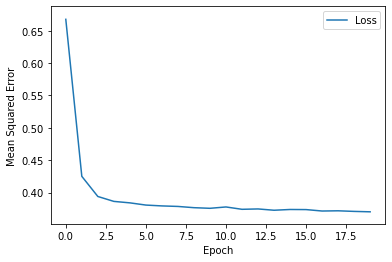


 Evaluate the new model against the test set:
3000/3000 [==============================] - 0s 17us/sample - loss: 0.4002 - mean_squared_error: 0.4002


[0.4002168079217275, 0.4002168]

In [28]:
learning_rate = 0.01
epochs = 20
batch_size = 1000

# Specify the label
label_name = "median_house_value"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined by the feature_layer.
epochs, mse = train_model(my_model, train_df_norm, epochs, 
                          label_name, batch_size)
plot_the_loss_curve(epochs, mse)

# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)